## Basic RNN Boiler Plate

### Keras Imports

In [1]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

### RNN Model Creation

In [2]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

demo_model = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

### Getting the weights parameters

In [4]:
wx = demo_model.get_weights()[0]
wh = demo_model.get_weights()[1]
bh = demo_model.get_weights()[2]
wy = demo_model.get_weights()[3]
by = demo_model.get_weights()[4]

print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-1.3382655 -1.2371802]]  wh =  [[ 0.6044682  0.7966292]
 [ 0.7966292 -0.6044683]]  bh =  [0. 0.]  wy = [[-0.5433221 ]
 [-0.94423336]] by =  [0.]


### Comaring Predictions

In [5]:
x = np.array([1, 2, 3])
# Reshape the input to the required sample_size x time_steps x features
x_input = np.reshape(x,(1, 3, 1))
y_pred_model = demo_model.predict(x_input)


m = 2
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
o3 = np.dot(h3, wy) + by

print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3)

print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o3)

1/1 [==============================] - 0s 383ms/step
h1 =  [[-1.33826554 -1.23718023]] h2 =  [[-4.47104396 -2.79262564]] h3 =  [[-8.94208773 -5.58525119]]
Prediction from network  [[10.132214]]
Prediction from our computation  [[10.13221425]]


## Time Series using RNN

In [6]:
 def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
train_data, test_data, data = get_train_test(sunspots_url)

In [8]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [9]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
187/187 - 3s - loss: 0.0810 - 3s/epoch - 15ms/step
Epoch 2/10
187/187 - 1s - loss: 0.0176 - 757ms/epoch - 4ms/step
Epoch 3/10
187/187 - 1s - loss: 0.0097 - 792ms/epoch - 4ms/step
Epoch 4/10
187/187 - 1s - loss: 0.0070 - 805ms/epoch - 4ms/step
Epoch 5/10
187/187 - 1s - loss: 0.0055 - 779ms/epoch - 4ms/step
Epoch 6/10
187/187 - 1s - loss: 0.0048 - 907ms/epoch - 5ms/step
Epoch 7/10
187/187 - 1s - loss: 0.0046 - 1s/epoch - 6ms/step
Epoch 8/10
187/187 - 1s - loss: 0.0043 - 1s/epoch - 6ms/step
Epoch 9/10
187/187 - 1s - loss: 0.0042 - 986ms/epoch - 5ms/step
Epoch 10/10
187/187 - 1s - loss: 0.0042 - 796ms/epoch - 4ms/step


In [10]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 34ms/step
Train RMSE: 0.065 RMSE
Test RMSE: 0.097 RMSE


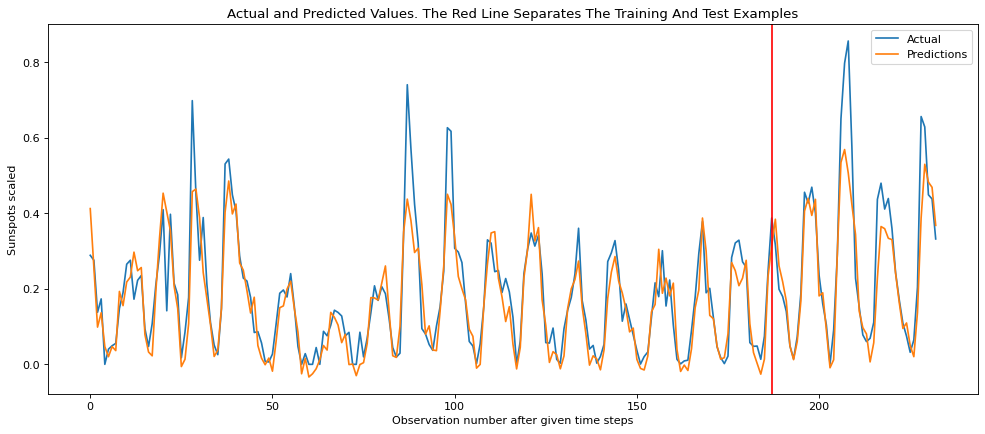

In [11]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
plot_result(trainY, testY, train_predict, test_predict)